In [21]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define your root path
root_path = r"new_collect"

data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Reshape data to combine the first three dimensions; each row corresponds to one observation across the 10 channels
X_reshaped = X.reshape(-1, X.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# Run PCA to examine channel contributions
pca = PCA(n_components=10)
pca.fit(X_reshaped)



Loading processed data...
Data shape: (2499, 19, 100, 10), Labels shape: (2499,)
Reshaped data for PCA: (4748100, 10)


PCA(n_components=10)

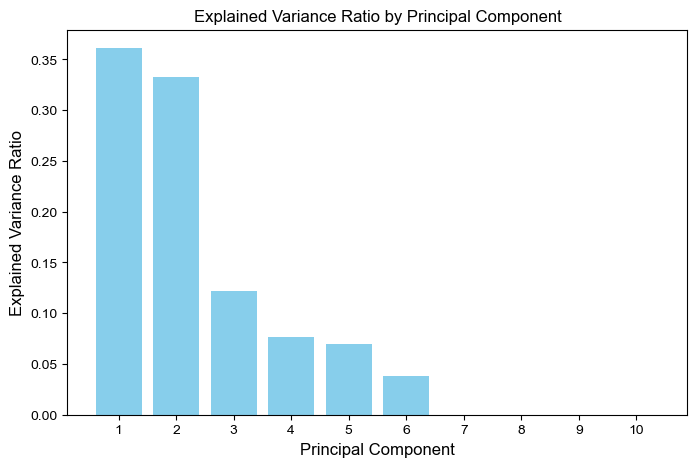

In [22]:
# Plot explained variance ratio per component
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(components)
plt.show()



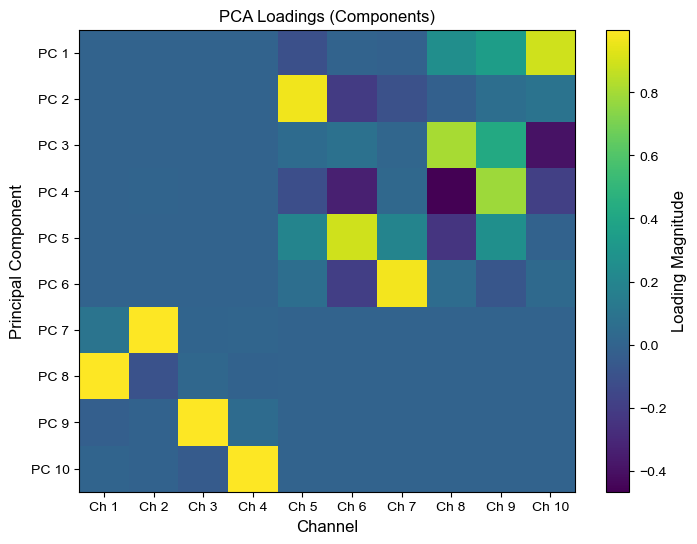

In [23]:
# Visualize the PCA loadings as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar(label='Loading Magnitude')
plt.xlabel('Channel')
plt.ylabel('Principal Component')
plt.title('PCA Loadings (Components)')
plt.xticks(np.arange(10), [f"Ch {i+1}" for i in range(10)])
plt.yticks(np.arange(10), [f"PC {i+1}" for i in range(10)])
plt.show()

In [24]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """Loads gesture dataset and splits into train/test sets."""
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path, allow_pickle=True)
    y = np.load(label_path, allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

def extract_emg_features(signal, fs=1000):
    """Extracts features from an EMG signal (100 time steps)."""
    mav = np.mean(np.abs(signal))  # Mean Absolute Value
    rms = np.sqrt(np.mean(signal**2))  # Root Mean Square
    var = np.var(signal)  # Variance
    zc = np.sum(np.diff(np.sign(signal)) != 0)  # Zero Crossing Count
    wl = np.sum(np.abs(np.diff(signal)))  # Waveform Length

    # Frequency-domain features using FFT
    fft_vals = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    power = np.abs(fft_vals)**2
    total_power = np.sum(power)
    mean_freq = np.sum(freqs * power) / total_power if total_power else 0

    cumsum_power = np.cumsum(power)
    median_freq = freqs[np.where(cumsum_power >= total_power/2)[0][0]] if total_power else 0

    return np.array([mav, rms, var, zc, wl, mean_freq, median_freq])

def synthesize_time_series(features, num_timesteps=100):
    """
    Generates a synthetic time series of length `num_timesteps` from extracted features.
    Uses Gaussian noise centered at the mean feature values.
    """
    synthesized_signal = np.zeros((num_timesteps,))
    
    for i, feature in enumerate(features):
        synthesized_signal += feature * np.sin(2 * np.pi * (i + 1) * np.linspace(0, 1, num_timesteps))
    
    return synthesized_signal + np.random.normal(0, 0.05, num_timesteps)  # Add small noise

def replace_emg_with_synthetic_data(X, fs=1000):
    """
    Replaces the first 4 EMG channels in each window with synthesized time series
    generated from extracted features, while keeping the last 6 IMU channels unchanged.

    Parameters:
    - X: Shape (num_samples, num_windows, num_timesteps, num_channels)
    - fs: Sampling frequency

    Returns:
    - X_new: Same shape as X, but with EMG channels replaced by synthetic features
    """
    num_samples, num_windows, num_timesteps, num_channels = X.shape
    new_X = np.copy(X)  # Keep the original structure

    for i in range(num_samples):
        for j in range(num_windows):
            for ch in range(4):  # Replace only the first 4 EMG channels
                features = extract_emg_features(X[i, j, :, ch], fs)
                new_X[i, j, :, ch] = synthesize_time_series(features, num_timesteps)

    return new_X

# Load original data
data_folder = r"new_collect"  
X_train, X_test, y_train, y_test = load_data(data_folder)

# Replace EMG channels with synthesized time series
# X_train_new = replace_emg_with_synthetic_data(X_train, fs=1000)
# X_test_new = replace_emg_with_synthetic_data(X_test, fs=1000)
X_new = replace_emg_with_synthetic_data(X, fs=1000)

# print(f"New training data shape: {X_train_new.shape}")
# print(f"New testing data shape: {X_test_new.shape}")

print(f"New data shape: {X_new.shape}")


Loading processed data...
Data shape: (2499, 19, 100, 10), Labels shape: (2499,)
Training set: (1999, 19, 100, 10), Testing set: (500, 19, 100, 10)
New data shape: (2499, 19, 100, 10)


Loading processed data...


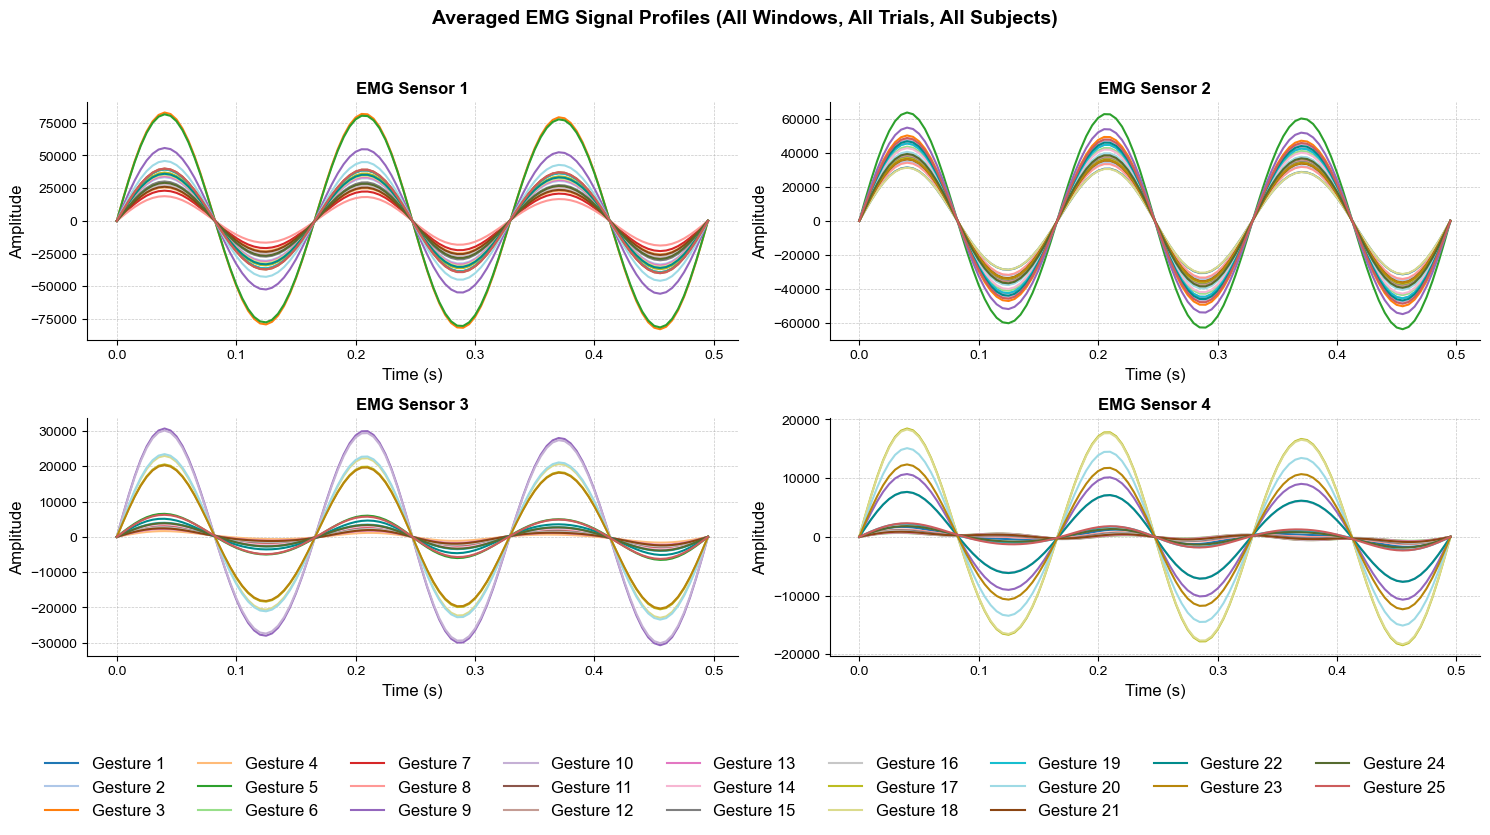

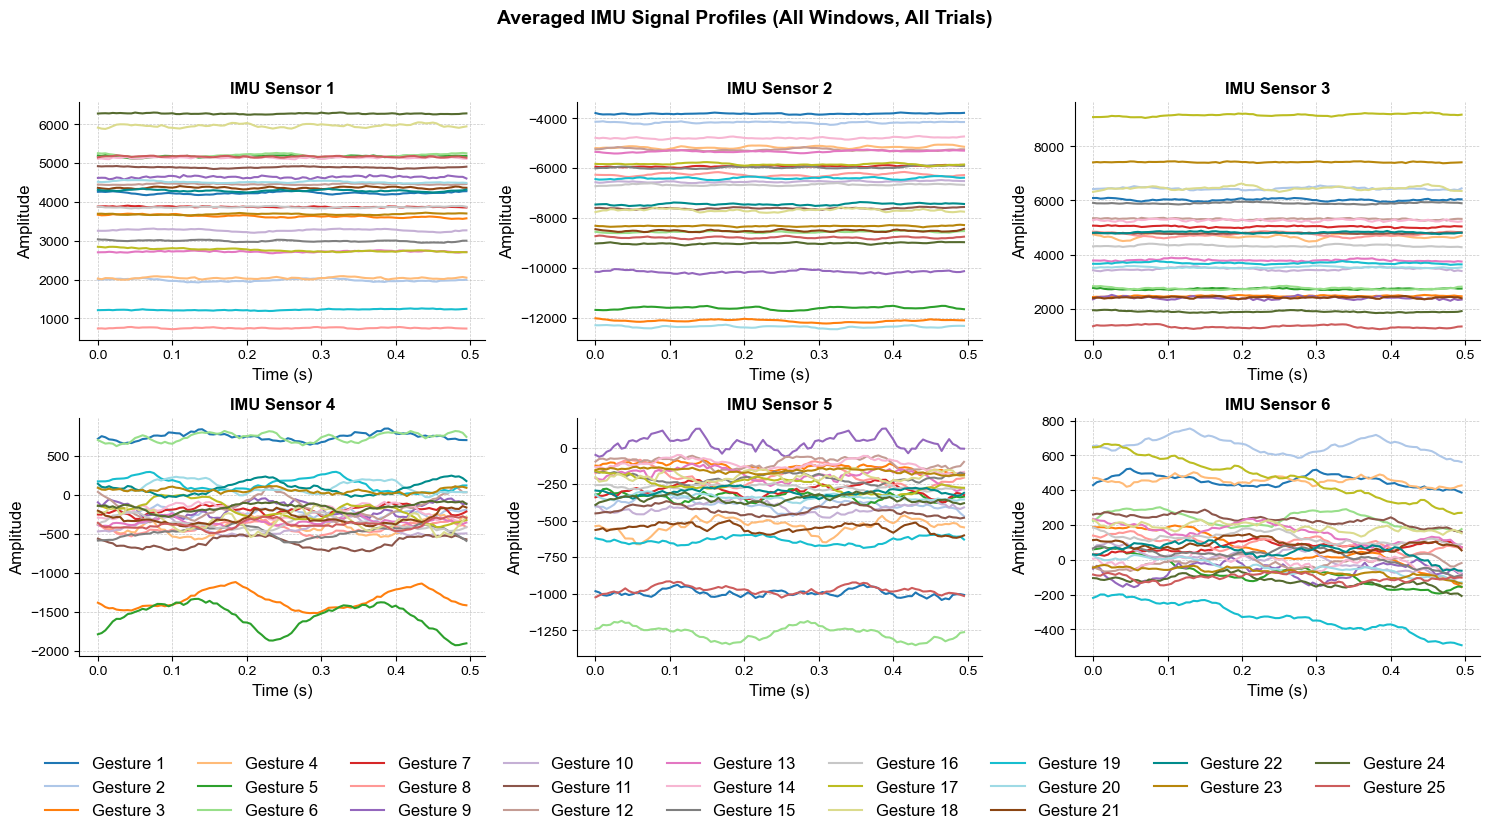

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --------------------------------------------------
# 1) IEEE-Style Figure Settings via rcParams
# --------------------------------------------------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 14

# --------------------------------------------------
# 2) User-Defined Parameters
# --------------------------------------------------
sampling_rate = 200  # Hz
emg_channels = [0, 1, 2, 3]
imu_channels = [4, 5, 6, 7, 8, 9]

# --------------------------------------------------
# 3) Load Processed Data
# --------------------------------------------------
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError(
        "Processed gesture data or labels not found. "
        "Please run process_all_gesture_files first."
    )

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)   # (n_trials, n_windows, window_length, n_channels)
y = np.load(label_path, allow_pickle=True)

# # If you have merged data, replace X and y here:
X = X_new
# y = np.concatenate([y_train, y_test], axis=0)

# --------------------------------------------------
# 4) Compute Mean Profiles (No Std)
# --------------------------------------------------
unique_gestures = np.sort(np.unique(y))
n_gestures = len(unique_gestures)

avg_profiles = {}
for gesture in unique_gestures:
    gesture_indices = np.where(y == gesture)[0]
    # Concatenate windows from all trials => shape: (N * n_windows, window_length, n_channels)
    gesture_data = np.concatenate([X[idx] for idx in gesture_indices], axis=0)
    # Mean across axis=0 => shape: (window_length, n_channels)
    avg_profiles[gesture] = np.mean(gesture_data, axis=0)

# --------------------------------------------------
# 5) Prepare Time Axis (Seconds)
# --------------------------------------------------
window_length = next(iter(avg_profiles.values())).shape[0]
time_axis = np.arange(window_length) / sampling_rate

# --------------------------------------------------
# 6) Define a Color Palette
# --------------------------------------------------
base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
extra_colors = ["#8B4513", "#008B8B", "#B8860B", "#556B2F",
                "#CD5C5C", "#4B0082", "#006400", "#8B008B"]
colors = list(base_colors) + extra_colors
colors = colors[:n_gestures]  # Ensure we have enough distinct colors

# --------------------------------------------------
# 7) Plot EMG Profiles (2×2 Layout)
# --------------------------------------------------
fig_emg, axes_emg = plt.subplots(2, 2, figsize=(15, 8), sharex=False, sharey=False)
axes_emg = axes_emg.flatten()

fig_emg.suptitle("Averaged EMG Signal Profiles (All Windows, All Trials, All Subjects)",
                 fontweight='bold', y=0.98)

# Plot each EMG channel
for i, ch in enumerate(emg_channels):
    ax = axes_emg[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        ax.plot(
            time_axis,
            avg_signal,
            color=colors[gesture_idx],
            linewidth=1.5,
            label=f"Gesture {gesture}"
        )
    
    ax.set_title(f"EMG Sensor {ch+1}", fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Collect legend handles/labels from all subplots
handles, labels = [], []
for ax in axes_emg:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while preserving order
legend_dict = {}
for h, l in zip(handles, labels):
    if l not in legend_dict:
        legend_dict[l] = h

# Single legend at the bottom (no bounding box)
fig_emg.legend(
    legend_dict.values(), legend_dict.keys(),
    loc='lower center', ncol=9, frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# --------------------------------------------------
# 8) Plot IMU Profiles (2×3 Layout)
# --------------------------------------------------
fig_imu, axes_imu = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
axes_imu = axes_imu.flatten()

fig_imu.suptitle("Averaged IMU Signal Profiles (All Windows, All Trials)",
                 fontweight='bold', y=0.98)

for i, ch in enumerate(imu_channels):
    ax = axes_imu[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        ax.plot(
            time_axis,
            avg_signal,
            color=colors[gesture_idx],
            linewidth=1.5,
            label=f"Gesture {gesture}"
        )
    
    # Renumber IMU sensors for clarity
    imu_label = ch - imu_channels[0] + 1
    ax.set_title(f"IMU Sensor {imu_label}", fontweight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Collect legend handles/labels from all subplots
handles, labels = [], []
for ax in axes_imu:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

legend_dict = {}
for h, l in zip(handles, labels):
    if l not in legend_dict:
        legend_dict[l] = h

fig_imu.legend(
    legend_dict.values(), legend_dict.keys(),
    loc='lower center', ncol=9, frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


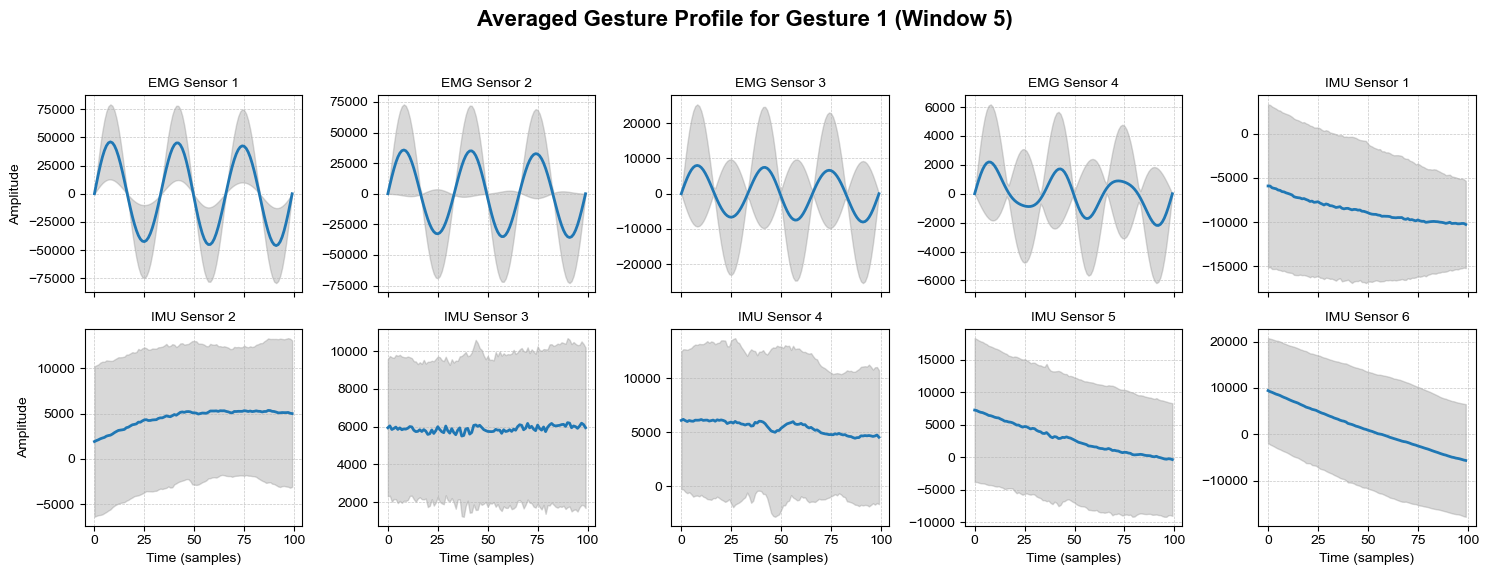

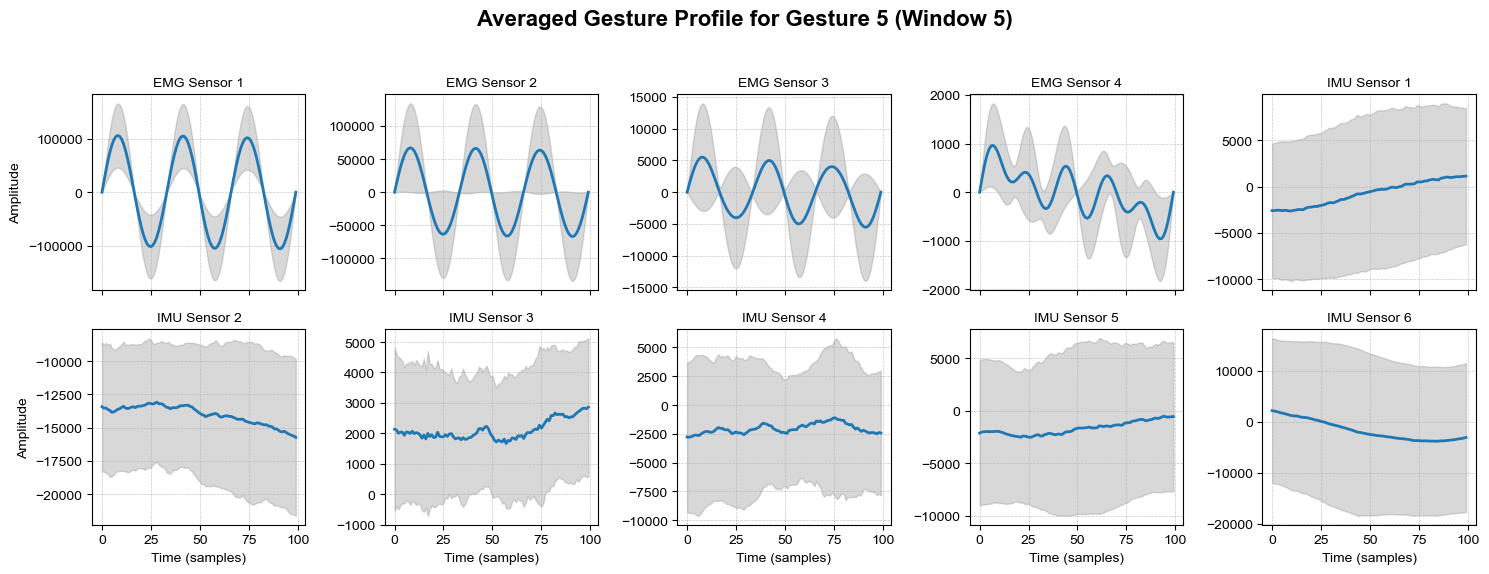

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the root path where processed data is stored

# # Load processed data and labels
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)
# y = np.load(label_path, allow_pickle=True)

# Define a helper function to extract a representative trial signal.
# If the processed data is 4D (n_trials, n_windows, window_length, n_channels),
# we select the first window as the representative window.
if X.ndim == 4:
    get_representative_trial = lambda idx: X[idx, 5, :, :]
elif X.ndim == 3:
    get_representative_trial = lambda idx: X[idx, :, :]
else:
    raise ValueError("Unexpected dimensions in processed gesture data")

# For each gesture, compute and plot the averaged gesture profile
unique_gestures = np.unique(y)

for gesture in [1, 5]: # unique_gestures
    indices = np.where(y == gesture)[0]
    if len(indices) == 0:
        continue

    # Extract a representative window from each trial for the current gesture
    trials = [get_representative_trial(idx) for idx in indices]
    trials = np.array(trials)  # Shape: (num_trials, window_length, n_channels)

    # Compute average and standard deviation across trials (axis=0)
    avg_signal = np.mean(trials, axis=0)
    std_signal = np.std(trials, axis=0)

    window_length = trials.shape[1]
    time_axis = np.arange(window_length)
    n_channels = trials.shape[2]

    # Create subplots for each sensor channel.
    # Assuming 10 channels (4 EMG and 6 IMU), we use 2 rows x 5 columns.
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6), sharex=True)
    fig.suptitle(f"Averaged Gesture Profile for Gesture {gesture} (Window 5)", fontsize=16, fontweight='bold')

    for ch in range(n_channels):
        ax = axes[ch // ncols, ch % ncols]
        # Plot the average signal with a thick line
        ax.plot(time_axis, avg_signal[:, ch], linewidth=2, label="Average")
        # Fill the area between average ± standard deviation
        ax.fill_between(time_axis,
                        avg_signal[:, ch] - std_signal[:, ch],
                        avg_signal[:, ch] + std_signal[:, ch],
                        color='gray', alpha=0.3, label="Std Dev")
        # Label sensor type: channels 0-3 are EMG, channels 4-9 are IMU
        if ch < 4:
            sensor_type = "EMG"
            sensor_id = ch + 1
        else:
            sensor_type = "IMU"
            sensor_id = ch - 3  # For example, channel 4 becomes IMU 1
        ax.set_title(f"{sensor_type} Sensor {sensor_id}", fontsize=10)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        if ch % ncols == 0:
            ax.set_ylabel("Amplitude", fontsize=10)
    # Set x-label on the bottom row subplots only
    for ax in axes[-1]:
        ax.set_xlabel("Time (samples)", fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Intra Subject Variability:

C:\Users\theof\AppData\Local\Temp\ipykernel_20940\73470152.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')  # 10 distinct colors


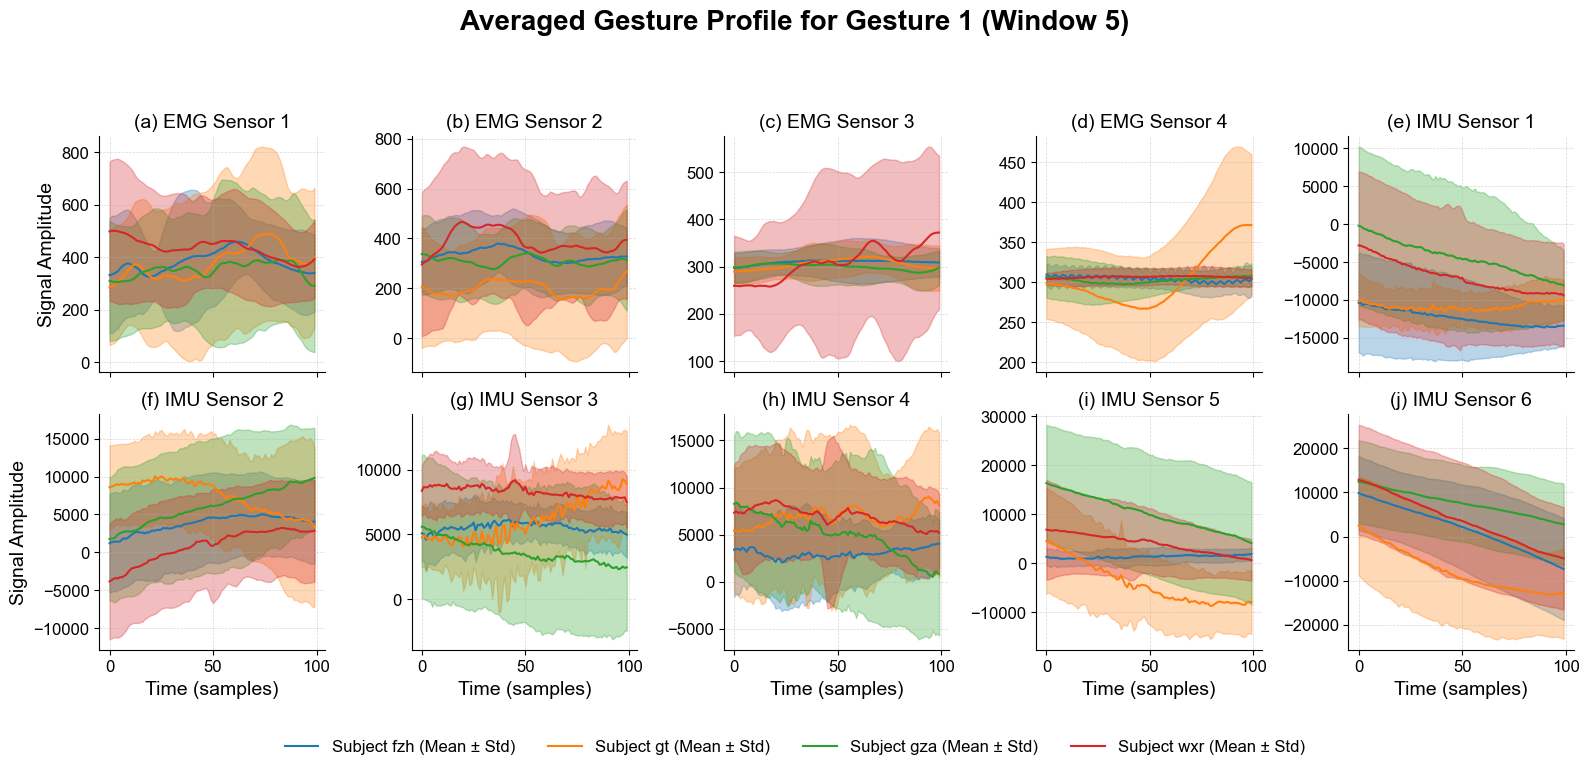

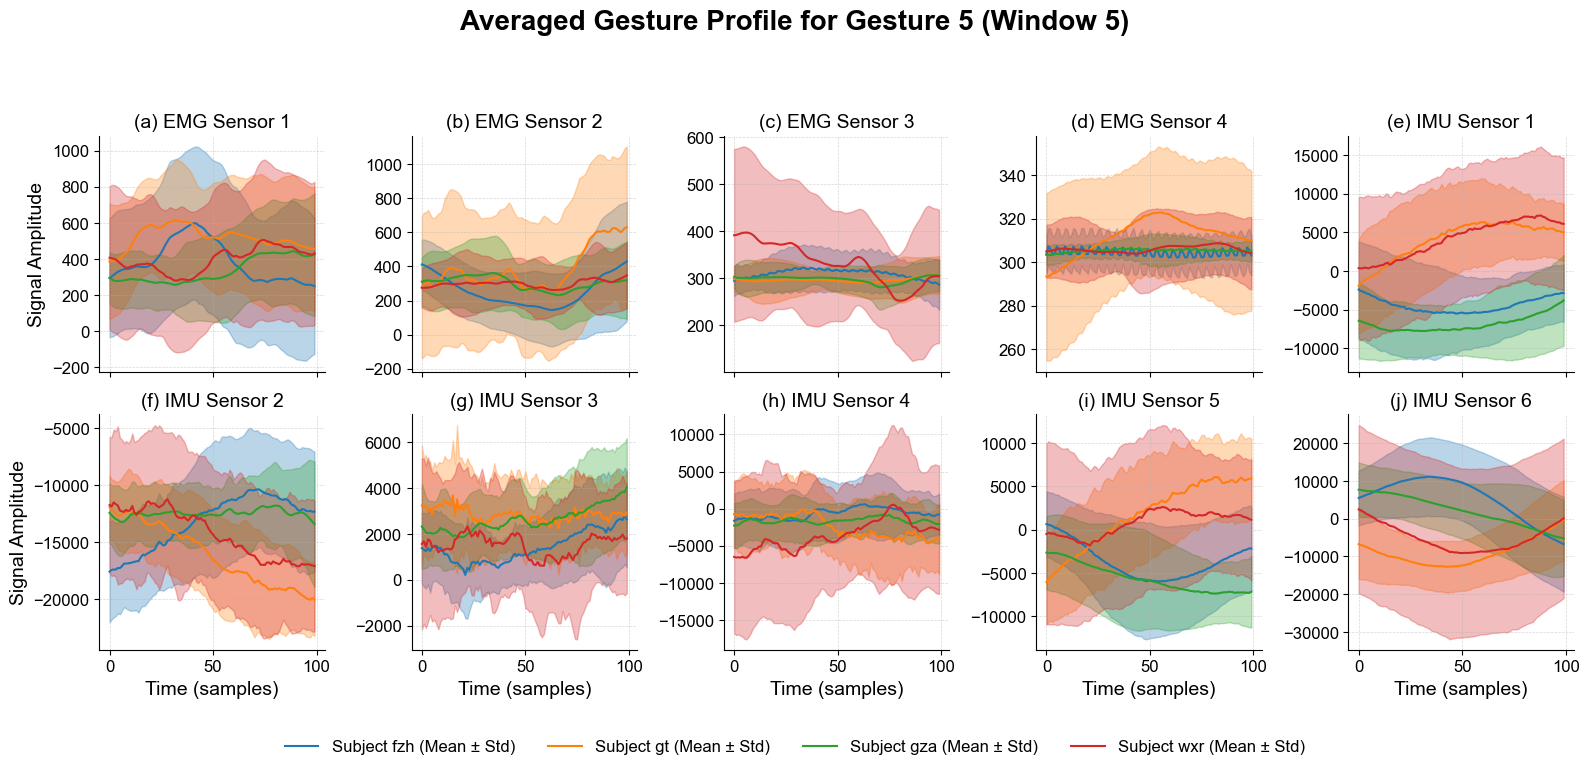

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# --------------------------------------------------
# 1) Configure IEEE-Style Figure Settings via rcParams
# --------------------------------------------------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.labelsize'] = 14       # Axis labels
mpl.rcParams['axes.titlesize'] = 14       # Axes titles
mpl.rcParams['legend.fontsize'] = 12      # Legend text
mpl.rcParams['xtick.labelsize'] = 12      # X-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12      # Y-axis tick labels

# If you want the suptitle bigger:
mpl.rcParams['figure.titlesize'] = 20


# Identify subject folders
subject_folders = [
    f for f in os.listdir(root_path)
    if os.path.isdir(os.path.join(root_path, f))
]

# Use a color-blind-friendly palette
color_map = plt.cm.get_cmap('tab10')  # 10 distinct colors
colors = color_map.colors

for gesture in [1, 5]:
    # 2 rows, 5 columns for subplots; bigger figure for larger text
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8), sharex=True)
    
    # Use rcParams for suptitle size; no explicit fontsize override
    fig.suptitle(f"Averaged Gesture Profile for Gesture {gesture} (Window 5)",
                 fontweight='bold')  # Let rcParams control size
    
    for subject_id, folder in enumerate(subject_folders):
        data_path = os.path.join(root_path, folder, "processed_gesture_data.npy")
        label_path = os.path.join(root_path, folder, "gesture_labels.npy")
        
        if not os.path.exists(data_path) or not os.path.exists(label_path):
            print(f"Skipping {folder}: Data or labels not found.")
            continue
        
        X = np.load(data_path, allow_pickle=True)
        y = np.load(label_path, allow_pickle=True)
        
        # Handle 3D vs. 4D data
        if X.ndim == 4:
            get_representative_trial = lambda idx: X[idx, 5, :, :]
        elif X.ndim == 3:
            get_representative_trial = lambda idx: X[idx, :, :]
        else:
            raise ValueError("Unexpected dimensions in gesture data.")
        
        # Extract trials for the current gesture
        indices = np.where(y == gesture)[0]
        if len(indices) == 0:
            continue
        
        trials = np.array([get_representative_trial(idx) for idx in indices])
        avg_signal = np.mean(trials, axis=0)
        std_signal = np.std(trials, axis=0)
        
        time_axis = np.arange(avg_signal.shape[0])
        n_channels = avg_signal.shape[1]
        
        # Single label per subject (Mean ± Std)
        subject_label = f"Subject {folder} (Mean ± Std)"
        
        for ch in range(n_channels):
            ax = axes[ch // ncols, ch % ncols]
            
            # Plot with legend only on first channel
            if ch == 0:
                ax.plot(time_axis, avg_signal[:, ch],
                        linewidth=1.5,
                        color=colors[subject_id % len(colors)],
                        label=subject_label)
                ax.fill_between(time_axis,
                                avg_signal[:, ch] - std_signal[:, ch],
                                avg_signal[:, ch] + std_signal[:, ch],
                                color=colors[subject_id % len(colors)],
                                alpha=0.3)
            else:
                ax.plot(time_axis, avg_signal[:, ch],
                        linewidth=1.5,
                        color=colors[subject_id % len(colors)])
                ax.fill_between(time_axis,
                                avg_signal[:, ch] - std_signal[:, ch],
                                avg_signal[:, ch] + std_signal[:, ch],
                                color=colors[subject_id % len(colors)],
                                alpha=0.3)
            
            # Determine sensor type
            if ch < 4:
                sensor_type = "EMG"
                sensor_id = ch + 1
            else:
                sensor_type = "IMU"
                sensor_id = ch - 3
            
            # Subplot labeling (no explicit fontsize override)
            subplot_label = chr(97 + ch)  # (a), (b), (c)...
            ax.set_title(f"({subplot_label}) {sensor_type} Sensor {sensor_id}")
            
            # Subtle grid, remove top/right spines
            ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            for side in ['top', 'right']:
                ax.spines[side].set_visible(False)
            
            # Leftmost column: y-axis label (no explicit fontsize override)
            if ch % ncols == 0:
                ax.set_ylabel("Signal Amplitude")
    
    # Bottom row: x-axis label (no explicit fontsize override)
    for ax in axes[-1]:
        ax.set_xlabel("Time (samples)")
    
    # Adjust layout to allow space for the legend at the bottom
    plt.tight_layout(rect=[0, 0.10, 1, 0.92])
    
    # Consolidate legend entries
    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    
    # Single legend at the bottom (no explicit fontsize override)
    fig.legend(by_label.values(), by_label.keys(),
               loc='lower center', ncol=4, frameon=False,
               bbox_to_anchor=(0.5, 0.03))
    
    plt.show()


In [28]:
root_path = r"new_collect"

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# --------------------------------------------------
# 3) Loading Data for Multiple Subjects
#    (One folder per subject, as in your previous approach)
# --------------------------------------------------

subject_folders = [
    f for f in os.listdir(root_path)
    if os.path.isdir(os.path.join(root_path, f))
]

# Lists to store original and synthetic data, along with labels
X_original_list = []
X_synthetic_list = []
y_list = []

for folder in subject_folders:
    data_path = os.path.join(root_path, folder, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, folder, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        print(f"Skipping {folder}: Data or labels not found.")
        continue
    
    print(f"Loading data for Subject {folder}...")
    X_subj = np.load(data_path, allow_pickle=True)  # shape: (nTrials, nWindows, nTimesteps, nChannels)
    y_subj = np.load(label_path, allow_pickle=True) # shape: (nTrials,)

    # Create synthetic version of the EMG channels
    X_synth_subj = replace_emg_with_synthetic_data(X_subj, fs=1000)

    X_original_list.append(X_subj)
    X_synthetic_list.append(X_synth_subj)
    y_list.append(y_subj)

# --------------------------------------------------
# 4) Plot: Separate Figure for Each Gesture
#    Each figure: 2 rows × 4 columns (4 EMG channels),
#    Top row = original, Bottom row = synthetic
#    Each subject is plotted in a different color
# --------------------------------------------------


Loading data for Subject fzh...
Loading data for Subject gt...
Loading data for Subject gza...
Loading data for Subject wxr...


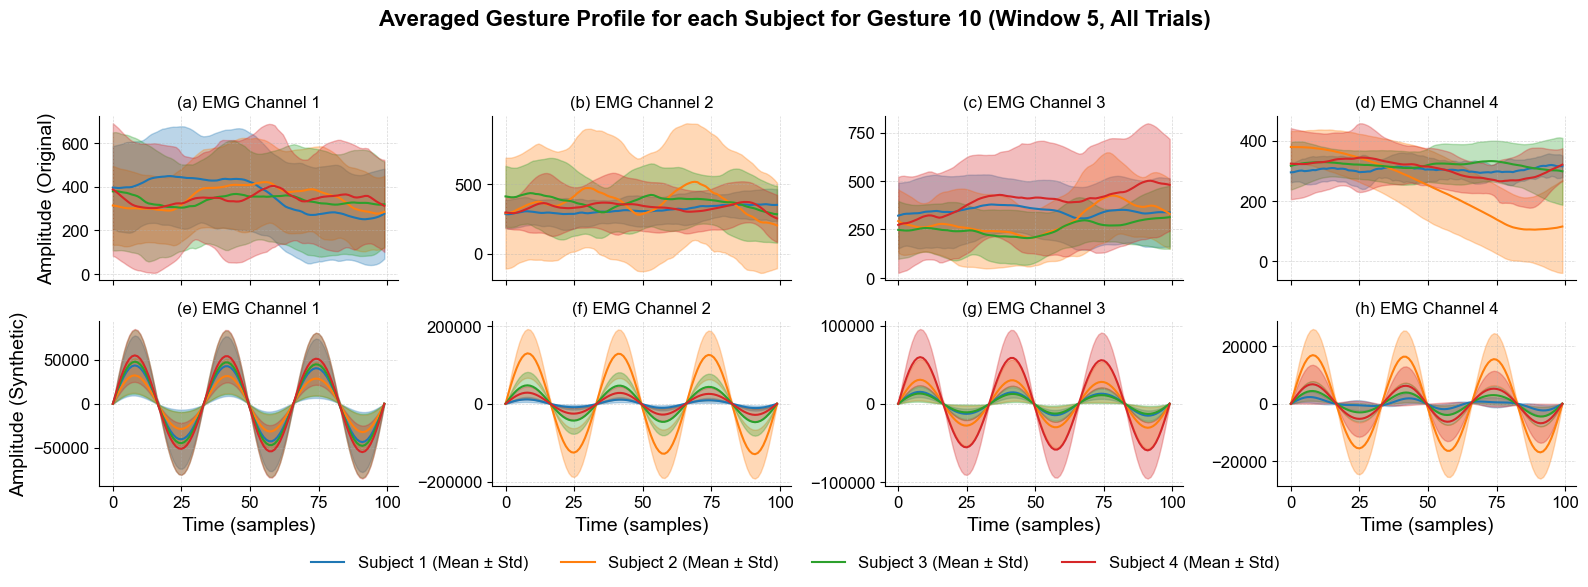

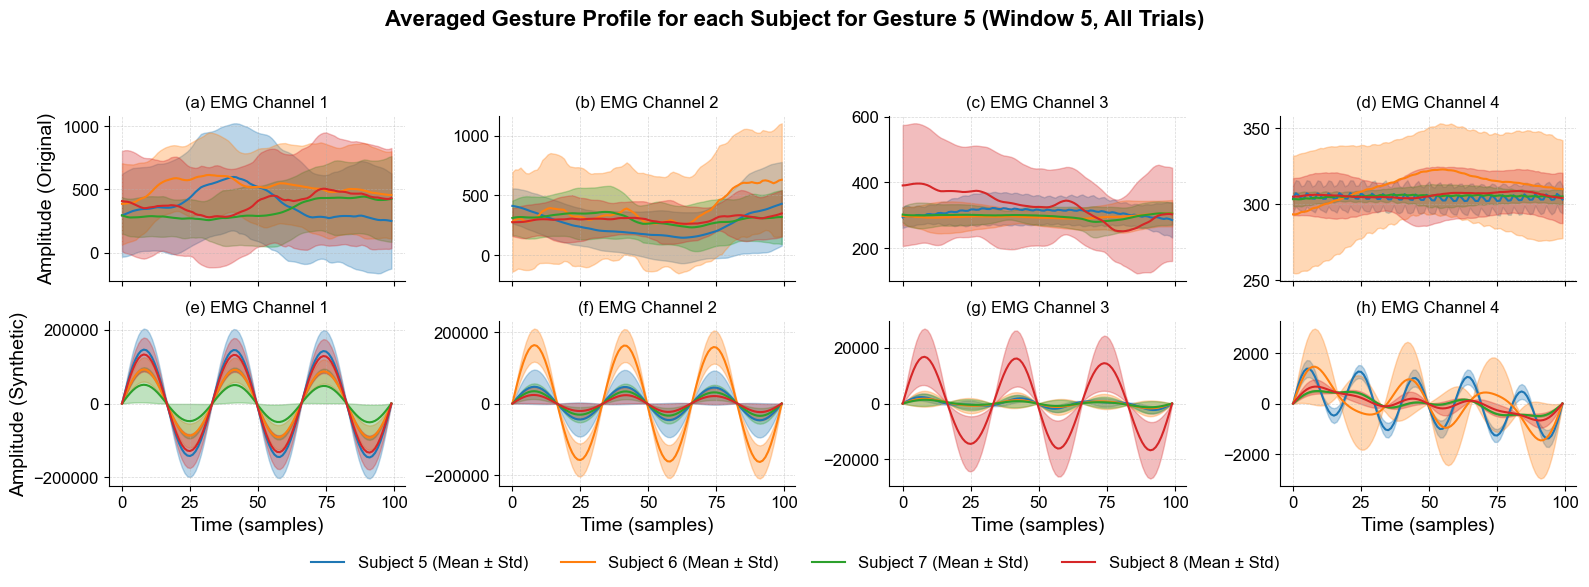

In [30]:

gestures_to_plot = [10, 5]  # e.g., gestures 1 and 5
WINDOW_IDX = 5  # which window index to visualize (if data has multiple windows)
colors = plt.cm.tab10.colors  # color-blind-friendly palette


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl



# Assume you already have:
#  - subject_folders (list of subject IDs/folder names)
#  - X_original_list (list of original data, one entry per subject)
#  - X_synthetic_list (list of synthetic data, one entry per subject)
#  - y_list (list of labels, one entry per subject)
#  - gestures_to_plot (e.g. [1, 5])
#  - WINDOW_IDX (e.g. 5) which window to visualize

i =0
for gesture in gestures_to_plot:
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True)
    fig.suptitle(f"Averaged Gesture Profile for each Subject for Gesture {gesture} (Window {WINDOW_IDX}, All Trials)",
                 fontsize=16, fontweight='bold')
    
    # Keep a dictionary of legend handles to avoid duplicates
    legend_handles = {}
    
    for subject_id, folder in enumerate(subject_folders):
        X_subj_original = X_original_list[subject_id]
        X_subj_synthetic = X_synthetic_list[subject_id]
        y_subj = y_list[subject_id]
        
        # Filter trials for this gesture
        trial_indices = np.where(y_subj == gesture)[0]
        if len(trial_indices) == 0:
            continue
        
        # Select a single window index and only the first 4 EMG channels
        subset_original = X_subj_original[trial_indices, WINDOW_IDX, :, :4]
        subset_synthetic = X_subj_synthetic[trial_indices, WINDOW_IDX, :, :4]
        
        # Compute mean ± std across trials
        mean_original = np.mean(subset_original, axis=0)  # shape (timesteps, 4)
        std_original  = np.std(subset_original, axis=0)
        
        mean_synthetic = np.mean(subset_synthetic, axis=0)
        std_synthetic  = np.std(subset_synthetic, axis=0)
        
        time_axis = np.arange(mean_original.shape[0])
        color = colors[subject_id % len(colors)]
        i+=1
        subj_label = f"Subject {i} (Mean ± Std)"
        
        for ch in range(4):
            # -- Top row => Original --
            ax_orig = axes[0, ch]
            line_orig, = ax_orig.plot(
                time_axis, mean_original[:, ch],
                linewidth=1.5, color=color,
                label=subj_label
            )
            ax_orig.fill_between(
                time_axis,
                mean_original[:, ch] - std_original[:, ch],
                mean_original[:, ch] + std_original[:, ch],
                color=color, alpha=0.3
            )
            
            # -- Bottom row => Synthetic --
            ax_synth = axes[1, ch]
            ax_synth.plot(
                time_axis, mean_synthetic[:, ch],
                linewidth=1.5, color=color
            )
            ax_synth.fill_between(
                time_axis,
                mean_synthetic[:, ch] - std_synthetic[:, ch],
                mean_synthetic[:, ch] + std_synthetic[:, ch],
                color=color, alpha=0.3
            )
            
            # Store the handle once for the legend
            if subj_label not in legend_handles:
                legend_handles[subj_label] = line_orig
            
            # Leftmost column: add y-axis labels
            if ch == 0:
                ax_orig.set_ylabel("Amplitude (Original)")
                ax_synth.set_ylabel("Amplitude (Synthetic)")
            
            # Subplot labels (a–d) top row, (e–h) bottom row
            top_label = chr(97 + ch)       # (a), (b), (c), (d)
            bot_label = chr(97 + 4 + ch)   # (e), (f), (g), (h)
            ax_orig.set_title(f"({top_label}) EMG Channel {ch+1}", fontsize=12)
            ax_synth.set_title(f"({bot_label}) EMG Channel {ch+1}", fontsize=12)
            
            # Grid and spines
            ax_orig.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            ax_synth.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            for side in ['top', 'right']:
                ax_orig.spines[side].set_visible(False)
                ax_synth.spines[side].set_visible(False)
    
    # X-axis label on the bottom row
    for ch in range(4):
        axes[1, ch].set_xlabel("Time (samples)")
    
    # Adjust layout to allow space for legend at the bottom
    plt.tight_layout(rect=[0, 0.08, 1, 0.92])
    
    # Single legend at the bottom
    fig.legend(
        legend_handles.values(), legend_handles.keys(),
        loc='lower center', ncol=4, frameon=False,
        bbox_to_anchor=(0.5, 0.02)
    )
    
    plt.show()



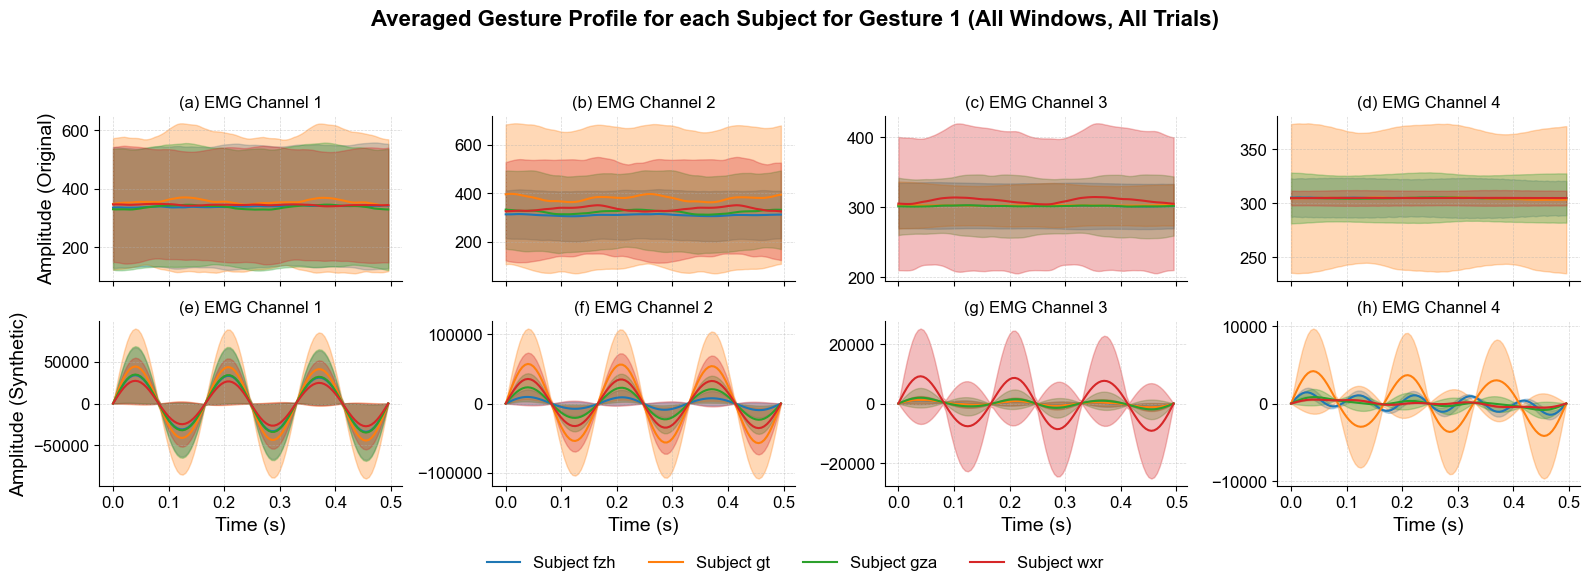

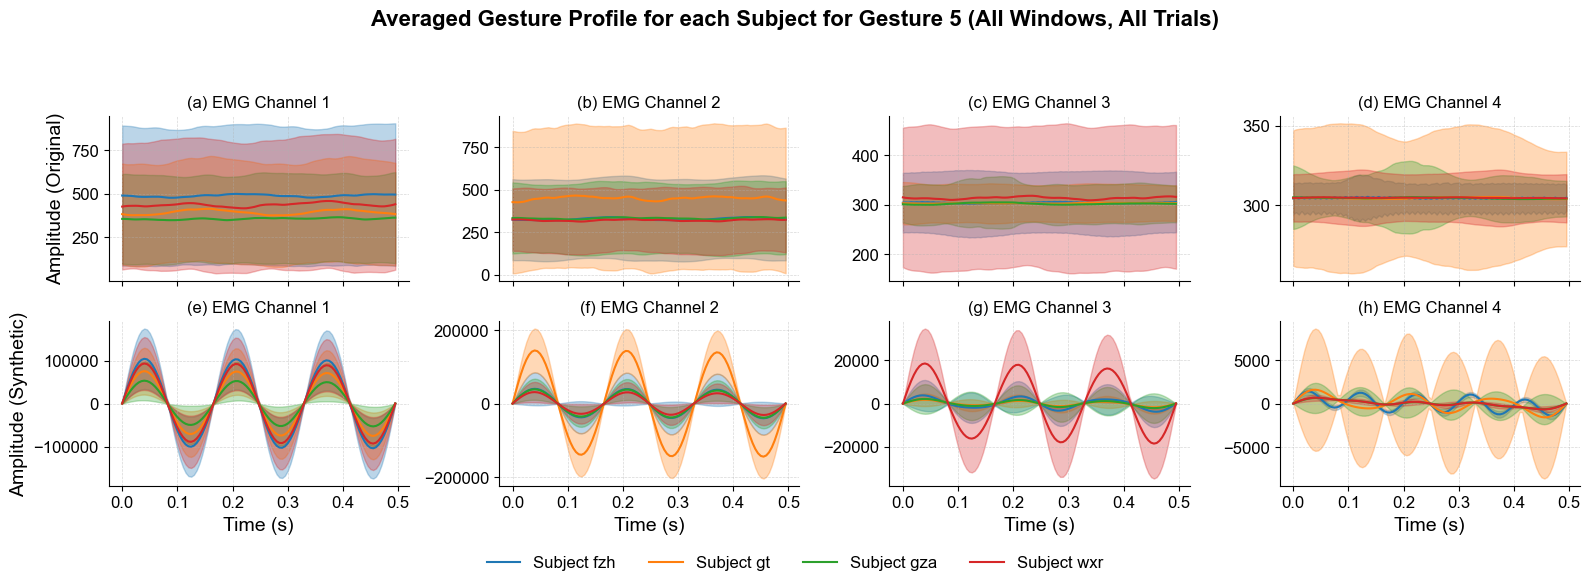

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Sampling rate for EMG signals
SAMPLING_RATE = 200  # Hz


# --------------------------------------------------
# 4) Plot Each Gesture: All Windows Averaged
#    - 2 rows × 4 columns (4 EMG channels)
#    - Top row: Original (mean ± std)
#    - Bottom row: Synthetic (mean ± std)
#    - Time axis in seconds => sample_index / SAMPLING_RATE
# --------------------------------------------------
gestures_to_plot = [1, 5]  # Example gestures

colors = plt.cm.tab10.colors  # color-blind-friendly palette

for gesture in gestures_to_plot:
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True)
    fig.suptitle(f"Averaged Gesture Profile for each Subject for Gesture {gesture} (All Windows, All Trials)",
                 fontsize=16, fontweight='bold')
    
    # Dictionary of handles for the legend (avoid duplicates)
    legend_handles = {}
    
    for subject_id, folder in enumerate(subject_folders):
        X_subj_original = X_original_list[subject_id]
        X_subj_synthetic = X_synthetic_list[subject_id]
        y_subj = y_list[subject_id]
        
        # Get trials for this gesture
        trial_indices = np.where(y_subj == gesture)[0]
        if len(trial_indices) == 0:
            continue
        
        # Slice out (nTrialsForGesture, nWindows, nTimesteps, 4 EMG channels)
        subset_original = X_subj_original[trial_indices, :, :, :4]
        subset_synthetic = X_subj_synthetic[trial_indices, :, :, :4]
        
        # Reshape to combine trials and windows => (N * nWindows, nTimesteps, 4)
        subset_orig_2d = subset_original.reshape(-1, subset_original.shape[2], 4)
        subset_synth_2d = subset_synthetic.reshape(-1, subset_synthetic.shape[2], 4)
        
        # Compute mean ± std across (all trials × all windows)
        mean_original = np.mean(subset_orig_2d, axis=0)  # (nTimesteps, 4)
        std_original  = np.std(subset_orig_2d, axis=0)
        
        mean_synthetic = np.mean(subset_synth_2d, axis=0)
        std_synthetic  = np.std(subset_synth_2d, axis=0)
        
        # Convert sample indices to time in seconds
        n_timesteps = mean_original.shape[0]
        time_axis = np.arange(n_timesteps) / SAMPLING_RATE
        
        # Subject label & color
        color = colors[subject_id % len(colors)]
        subj_label = f"Subject {folder}"

        # Plot each of the 4 EMG channels
        for ch in range(4):
            # Top row => original
            ax_orig = axes[0, ch]
            line_orig, = ax_orig.plot(
                time_axis, mean_original[:, ch],
                linewidth=1.5, color=color, label=subj_label
            )
            ax_orig.fill_between(
                time_axis,
                mean_original[:, ch] - std_original[:, ch],
                mean_original[:, ch] + std_original[:, ch],
                color=color, alpha=0.3
            )
            
            # Bottom row => synthetic
            ax_synth = axes[1, ch]
            ax_synth.plot(
                time_axis, mean_synthetic[:, ch],
                linewidth=1.5, color=color
            )
            ax_synth.fill_between(
                time_axis,
                mean_synthetic[:, ch] - std_synthetic[:, ch],
                mean_synthetic[:, ch] + std_synthetic[:, ch],
                color=color, alpha=0.3
            )
            
            # Store legend handle once
            if subj_label not in legend_handles:
                legend_handles[subj_label] = line_orig
            
            # Y-axis labels for leftmost column
            if ch == 0:
                ax_orig.set_ylabel("Amplitude (Original)")
                ax_synth.set_ylabel("Amplitude (Synthetic)")
            
            # Subplot labeling: (a)–(h)
            top_label = chr(97 + ch)        # (a),(b),(c),(d) for top row
            bottom_label = chr(97 + 4 + ch) # (e),(f),(g),(h) for bottom row
            ax_orig.set_title(f"({top_label}) EMG Channel {ch+1}", fontsize=12)
            ax_synth.set_title(f"({bottom_label}) EMG Channel {ch+1}", fontsize=12)
            
            # Grid & remove top/right spines
            ax_orig.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            ax_synth.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            for side in ['top', 'right']:
                ax_orig.spines[side].set_visible(False)
                ax_synth.spines[side].set_visible(False)
    
    # X-axis label on the bottom row
    for ch in range(4):
        axes[1, ch].set_xlabel("Time (s)")  # now in seconds
    
    # Adjust layout for clarity & space for legend
    plt.tight_layout(rect=[0, 0.08, 1, 0.92])
    
    # Single legend at the bottom
    fig.legend(
        legend_handles.values(), legend_handles.keys(),
        loc='lower center', ncol=4, frameon=False,
        bbox_to_anchor=(0.5, 0.02)
    )
    
    plt.show()


# PCA/LDA

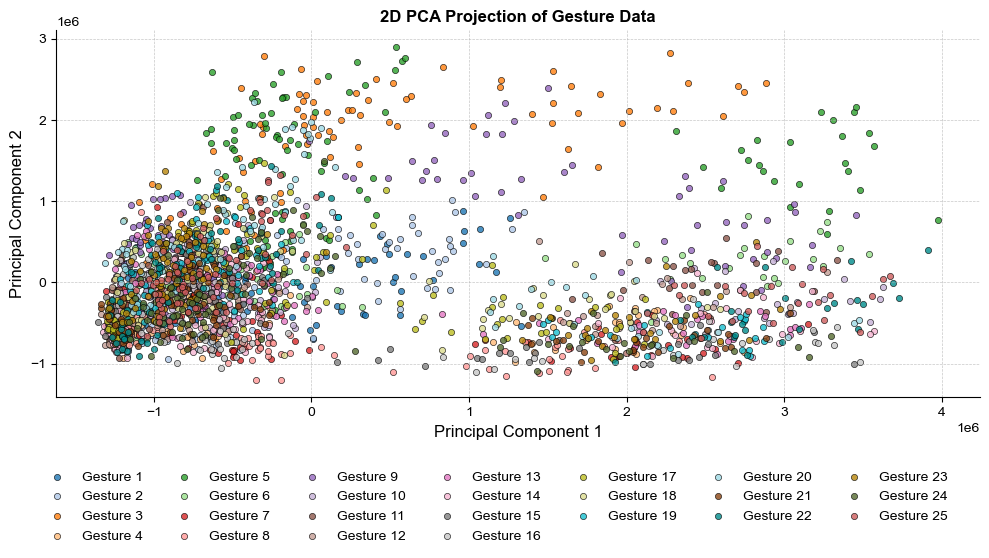

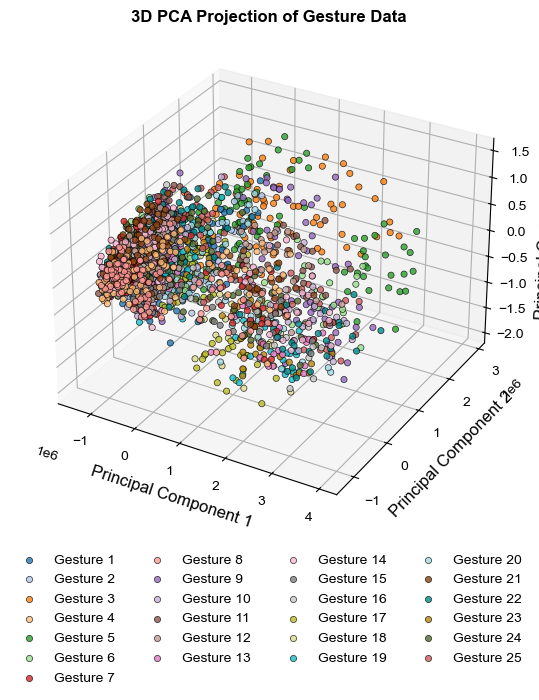

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------
# 1) Figure & Font Settings (IEEE-Style)
# --------------------------------------------------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = 0.8

# --------------------------------------------------
# 2) Load Data
# --------------------------------------------------
# root_path = "./data"  # Change if needed
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Data or labels not found.")

X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

X = X_new

# Flatten data for PCA
num_samples = X.shape[0]
num_features = np.prod(X.shape[1:])
X_reshaped = X.reshape(num_samples, num_features)

# --------------------------------------------------
# 3) Perform PCA
# --------------------------------------------------
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_reshaped)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_reshaped)

unique_labels = np.sort(np.unique(y))
n_labels = len(unique_labels)

# --------------------------------------------------
# 4) Color Palette
# --------------------------------------------------
base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
extra_colors = ["#8B4513", "#008B8B", "#B8860B", "#556B2F",
                "#CD5C5C", "#4B0082", "#006400", "#8B008B"]
colors = list(base_colors) + extra_colors
colors = colors[:n_labels]

# --------------------------------------------------
# 5) 2D PCA Plot
# --------------------------------------------------
fig_2d, ax_2d = plt.subplots(figsize=(10, 5))
ax_2d.set_title("2D PCA Projection of Gesture Data", fontweight='bold')

scatter_handles_2d = {}
for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0]
    sc = ax_2d.scatter(
        X_pca_2d[idx, 0], X_pca_2d[idx, 1],
        color=colors[i], s=20, alpha=0.8,
        edgecolors='black', linewidths=0.5,
        label=f"Gesture {label}"
    )
    scatter_handles_2d[label] = sc

ax_2d.set_xlabel("Principal Component 1")
ax_2d.set_ylabel("Principal Component 2")
ax_2d.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for spine in ["top", "right"]:
    ax_2d.spines[spine].set_visible(False)

labels_2d, handles_2d = zip(*scatter_handles_2d.items())  # CORRECT ORDER
# fig_2d.legend(handles_2d, [f"Gesture {lbl}" for lbl in labels_2d])
# Place legend below plot, closer to the axes
fig_2d.legend(
    handles_2d, [f"Gesture {lbl}" for lbl in labels_2d],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    frameon=False
)

plt.tight_layout(rect=[0, 0.001, 1, 0.92])
plt.show()

# --------------------------------------------------
# 6) 3D PCA Plot
# --------------------------------------------------
fig_3d = plt.figure(figsize=(12, 6))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.set_title("3D PCA Projection of Gesture Data", fontweight='bold')

scatter_handles_3d = {}
for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0]
    sc = ax_3d.scatter(
        X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2],
        color=colors[i], s=20, alpha=0.8,
        edgecolors='black', linewidths=0.5,
        label=f"Gesture {label}"
    )
    scatter_handles_3d[label] = sc

ax_3d.set_xlabel("Principal Component 1")
ax_3d.set_ylabel("Principal Component 2")
ax_3d.set_zlabel("Principal Component 3")

labels_3d, handles_3d = zip(*scatter_handles_3d.items())
# Legend placed closer but still below figure
fig_3d.legend(
    handles_3d, [f"Gesture {lbl}" for lbl in labels_3d],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)

plt.tight_layout(rect=[0, 0.01, 1, 0.92])
# plt.savefig("IEEE_3D_PCA.pdf", dpi=300, bbox_inches='tight')
plt.show()


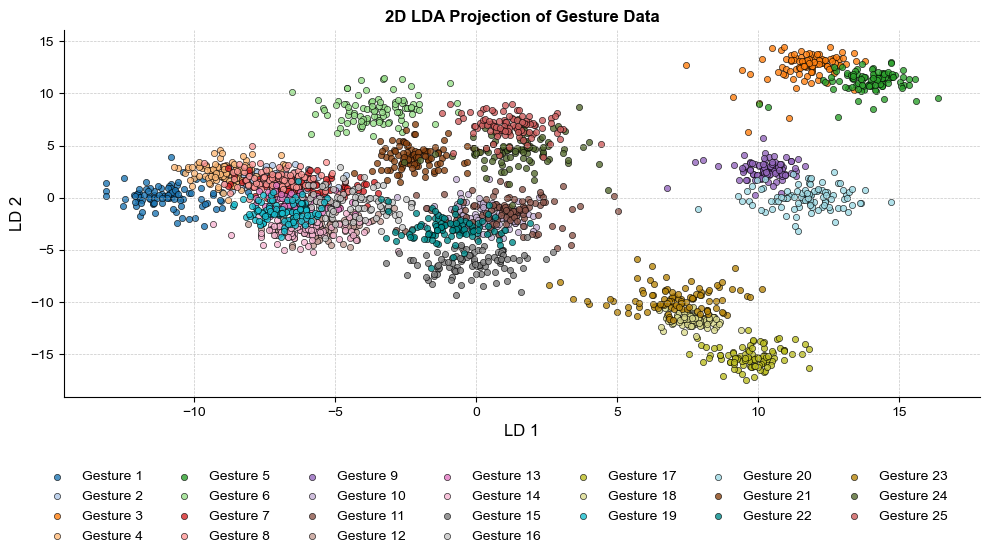

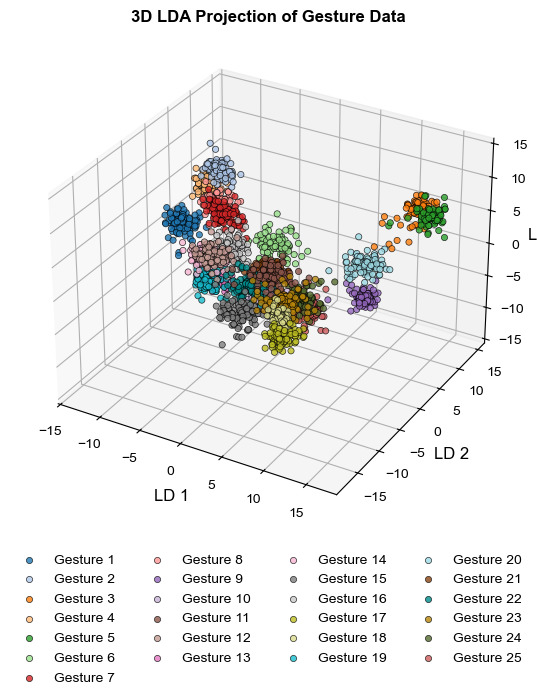

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# --------------------------------------------------
# 1) Figure & Font Settings (IEEE-Style)
# --------------------------------------------------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = 0.8

# --------------------------------------------------
# 2) Load Data
# --------------------------------------------------
# Adjust 'root_path' as needed
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Data or labels not found.")

X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# If you have merged data:
X = X_new

# Flatten data for LDA
num_samples = X.shape[0]
num_features = np.prod(X.shape[1:])
X_reshaped = X.reshape(num_samples, num_features)

# --------------------------------------------------
# 3) Perform LDA
# --------------------------------------------------
# LDA requires (X, y) and the number of components <= (n_classes - 1)
lda_2d = LinearDiscriminantAnalysis(n_components=2)
X_lda_2d = lda_2d.fit_transform(X_reshaped, y)

lda_3d = LinearDiscriminantAnalysis(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_reshaped, y)

unique_labels = np.sort(np.unique(y))
n_labels = len(unique_labels)

# --------------------------------------------------
# 4) Color Palette
# --------------------------------------------------
base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
extra_colors = ["#8B4513", "#008B8B", "#B8860B", "#556B2F",
                "#CD5C5C", "#4B0082", "#006400", "#8B008B"]
colors = list(base_colors) + extra_colors
colors = colors[:n_labels]

# --------------------------------------------------
# 5) 2D LDA Plot
# --------------------------------------------------
fig_2d, ax_2d = plt.subplots(figsize=(10, 5))
ax_2d.set_title("2D LDA Projection of Gesture Data", fontweight='bold')

scatter_handles_2d = {}
for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0]
    sc = ax_2d.scatter(
        X_lda_2d[idx, 0], X_lda_2d[idx, 1],
        color=colors[i], s=20, alpha=0.8,
        edgecolors='black', linewidths=0.5,
        label=f"Gesture {label}"
    )
    scatter_handles_2d[label] = sc

ax_2d.set_xlabel("LD 1")
ax_2d.set_ylabel("LD 2")
ax_2d.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for spine in ["top", "right"]:
    ax_2d.spines[spine].set_visible(False)

# IMPORTANT: unpack (label, handle) pairs in correct order
labels_2d, handles_2d = zip(*scatter_handles_2d.items())

# Multi-column legend placed below the plot
fig_2d.legend(
    handles_2d, [f"Gesture {lbl}" for lbl in labels_2d],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,           # Adjust columns as needed
    frameon=False
)

plt.tight_layout(rect=[0, 0.001, 1, 0.92])
plt.show()

# --------------------------------------------------
# 6) 3D LDA Plot
# --------------------------------------------------
fig_3d = plt.figure(figsize=(12, 6))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.set_title("3D LDA Projection of Gesture Data", fontweight='bold')

scatter_handles_3d = {}
for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0]
    sc = ax_3d.scatter(
        X_lda_3d[idx, 0], X_lda_3d[idx, 1], X_lda_3d[idx, 2],
        color=colors[i], s=20, alpha=0.8,
        edgecolors='black', linewidths=0.5,
        label=f"Gesture {label}"
    )
    scatter_handles_3d[label] = sc

ax_3d.set_xlabel("LD 1")
ax_3d.set_ylabel("LD 2")
ax_3d.set_zlabel("LD 3")

labels_3d, handles_3d = zip(*scatter_handles_3d.items())

# Legend placed closer but still below the figure
fig_3d.legend(
    handles_3d, [f"Gesture {lbl}" for lbl in labels_3d],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)

plt.tight_layout(rect=[0, 0.01, 1, 0.92])
# plt.savefig("IEEE_3D_LDA.pdf", dpi=300, bbox_inches='tight')
plt.show()


Merged feature data shape: (2499, 19, 100, 10)
Reshaped data for PCA: (4748100, 10)


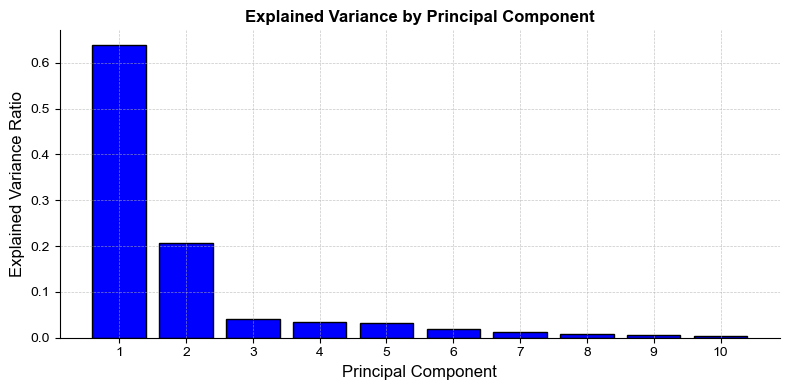

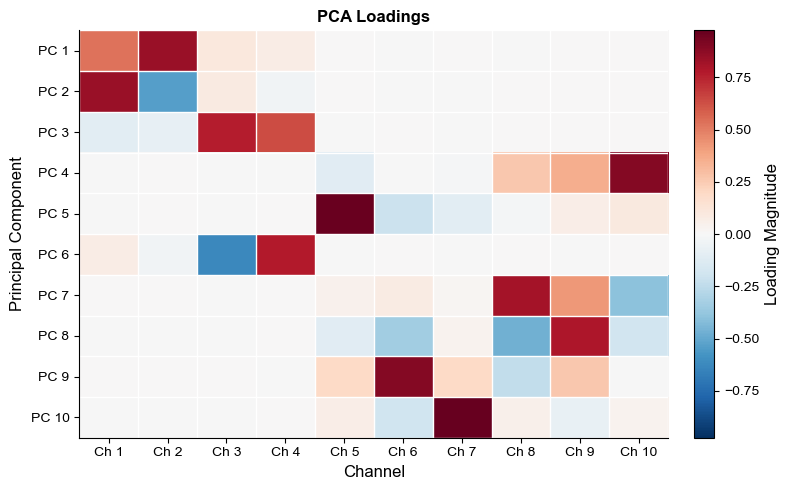

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from matplotlib.colors import TwoSlopeNorm  # For centering colormap at zero

# --------------------------------------------------
# 1) IEEE-Style Figure Settings (rcParams)
# --------------------------------------------------
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = 0.8
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# --------------------------------------------------
# 2) Merge & Reshape Data for PCA
# --------------------------------------------------
# Example: merging train/test feature sets
X_merged = X_new  # Replace with your own data source

print(f"Merged feature data shape: {X_merged.shape}")

# Reshape data so each row corresponds to one observation across channels
X_reshaped = X_merged.reshape(-1, X_merged.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# --------------------------------------------------
# 3) Run PCA
# --------------------------------------------------
n_components = min(10, X_reshaped.shape[1])
pca = PCA(n_components=n_components)
pca.fit(X_reshaped)

# --------------------------------------------------
# 4) Bar Plot of Explained Variance Ratio
# --------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 4))
components = np.arange(1, n_components + 1)
ax1.bar(components, pca.explained_variance_ratio_, color='blue', edgecolor='black')

ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Principal Component', fontweight='bold')
ax1.set_xticks(components)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Remove top/right spines for a cleaner IEEE look
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5) Heatmap of PCA Loadings (More Professional)
# --------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 5))
loadings = pca.components_

# If loadings can be both positive and negative, define a symmetrical range
min_val, max_val = loadings.min(), loadings.max()
abs_max = max(abs(min_val), abs(max_val))

# Center the colormap at 0 using TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0, vmin=-abs_max, vmax=abs_max)

# Use a diverging colormap for positive/negative loadings
im = ax2.imshow(loadings, aspect='auto', cmap='RdBu_r', norm=norm)

ax2.set_xlabel('Channel')
ax2.set_ylabel('Principal Component')
ax2.set_title('PCA Loadings', fontweight='bold')

n_channels = loadings.shape[1]  # Or 10 if you know the channel count
ax2.set_xticks(np.arange(n_channels))
ax2.set_xticklabels([f"Ch {i+1}" for i in range(n_channels)])
ax2.set_yticks(np.arange(n_components))
ax2.set_yticklabels([f"PC {i+1}" for i in range(n_components)])

# Optional: add thin gridlines to separate cells
ax2.set_xticks(np.arange(-0.5, n_channels, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, n_components, 1), minor=True)
ax2.grid(which='minor', color='white', linestyle='-', linewidth=1)
ax2.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Loading Magnitude')

# Remove top/right spines
for spine in ["top", "right"]:
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

X = X_new

# Reshape data to (num_samples, num_features) for classification
num_samples = X.shape[0]
num_features = X.shape[1] * X.shape[2] * X.shape[3]
X_reshaped = X.reshape(num_samples, num_features)

# Split the data into training and testing sets
test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Compute accuracy and misclassified count
accuracy = accuracy_score(y_test, y_pred)
misclassified_count = np.sum(y_pred != y_test)
print(f"KNN Accuracy: {accuracy:.4f}")
print(f"Number of Misclassified Points: {misclassified_count}")

# # Reduce test data to 2D using PCA for visualization
# pca = PCA(n_components=2)
# X_test_pca = pca.fit_transform(X_test)

# # Create a colormap for true labels using "rainbow"
# unique_labels = np.unique(y_test)
# cmap = plt.get_cmap("rainbow", len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]
# color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}

# # Identify correctly classified and misclassified indices
# correct_idx = np.where(y_pred == y_test)[0]
# misclassified_idx = np.where(y_pred != y_test)[0]

# # Plot the PCA projection with correct predictions and highlight misclassified points
# plt.figure(figsize=(10, 8))

# # Plot correctly classified points (color-coded by their true label)
# for idx in correct_idx:
#     true_label = y_test[idx]
#     plt.scatter(X_test_pca[idx, 0], X_test_pca[idx, 1],
#                 color=color_dict[true_label], marker='o', s=60,
#                 edgecolors='black', linewidth=0.5)

# # Highlight misclassified points with a distinct marker (red 'x')
# plt.scatter(X_test_pca[misclassified_idx, 0], X_test_pca[misclassified_idx, 1],
#             color='red', marker='x', s=100, label='Misclassified', linewidth=2)

# plt.xlabel("Principal Component 1", fontsize=12, fontweight='bold')
# plt.ylabel("Principal Component 2", fontsize=12, fontweight='bold')
# plt.title("KNN Classification on Gesture Data (2D PCA Projection)", fontsize=14, fontweight='bold')
# plt.legend(fontsize=10, loc='best', frameon=True)
# plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
# plt.show()


Loading processed data...
KNN Accuracy: 0.5860
Number of Misclassified Points: 207


In [1]:
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from PIL import ImageFont

# Example model with named layers
model = Sequential(name="My_1D_CNN")
model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=(19100, 1), name="Conv1D-1"))
model.add(BatchNormalization(name="BatchNorm-1"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-1"))

model.add(Conv1D(128, 3, activation='relu', padding='same', name="Conv1D-2"))
model.add(BatchNormalization(name="BatchNorm-2"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-2"))

model.add(Conv1D(256, 3, activation='relu', padding='same', name="Conv1D-3"))
model.add(BatchNormalization(name="BatchNorm-3"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-3"))

model.add(Flatten(name="Flatten"))
model.add(Dense(256, activation='relu', name="Dense-1"))
model.add(Dropout(0.5, name="Dropout-1"))
model.add(Dense(128, activation='relu', name="Dense-2"))
model.add(Dropout(0.5, name="Dropout-2"))
model.add(Dense(64, activation='relu', name="Dense-3"))
model.add(Dropout(0.3, name="Dropout-3"))
model.add(Dense(25, activation='softmax', name="Output"))

# Optional: custom text to display each layer's name + output shape
def my_text_callable(layer_index, layer):
    lines = [layer.name]
    shape = layer.output_shape
    if isinstance(shape, list) and shape:
        shape = shape[0]
    if isinstance(shape, tuple) and len(shape) > 1:
        shape_str = "x".join(str(dim) for dim in shape[1:])
        lines.append(f"Shape: {shape_str}")
    return "\n".join(lines), "black"

# Try loading a custom font; fallback to default if unavailable
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

# Generate the 3D layered view with funnels
image = visualkeras.layered_view(
    model,
    legend=True,                     # color-coded legend
    draw_volume=True,                # 3D boxes
    draw_funnel=True,                # connect layers with funnels
    one_dim_orientation='x',         # 1D layers along X-axis
    spacing=70,                      # reduce spacing for clearer funnels
    scale_xy=1.5,
    scale_z=1,
    shade_step=20,
    text_callable=my_text_callable,
    font=font,
    to_file="my_1dcnn_visual_funnels.png",  # save image
    padding=50
)

image.show()


c:\Users\theof\miniconda3\envs\grad_env\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [60]:
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from PIL import ImageFont

# Example 1D model with named layers
model = Sequential(name="My_1D_CNN")
model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=(19, 64), name="Conv1D-1"))
model.add(BatchNormalization(name="BatchNorm-1"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-1"))

model.add(Conv1D(128, 3, activation='relu', padding='same', name="Conv1D-2"))
model.add(BatchNormalization(name="BatchNorm-2"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-2"))

model.add(Conv1D(256, 3, activation='relu', padding='same', name="Conv1D-3"))
model.add(BatchNormalization(name="BatchNorm-3"))
model.add(MaxPooling1D(pool_size=2, name="MaxPool-3"))

model.add(Flatten(name="Flatten"))
model.add(Dense(256, activation='relu', name="Dense-1"))
model.add(Dropout(0.5, name="Dropout-1"))
model.add(Dense(128, activation='relu', name="Dense-2"))
model.add(Dropout(0.5, name="Dropout-2"))
model.add(Dense(64, activation='relu', name="Dense-3"))
model.add(Dropout(0.3, name="Dropout-3"))
model.add(Dense(23, activation='softmax', name="Output"))

# Optional: custom text to show layer name + shape
def my_text_callable(layer_index, layer):
    lines = [layer.name]
    shape = layer.output_shape
    if isinstance(shape, list) and shape:
        shape = shape[0]
    if isinstance(shape, tuple) and len(shape) > 1:
        shape_str = "x".join(str(dim) for dim in shape[1:])
        lines.append(f"Shape: {shape_str}")
    return "\n".join(lines), "black"

# Try loading a custom font
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

# Generate the 3D layered view with more "dramatic" perspective
image = visualkeras.layered_view(
    model,
    legend=True,
    draw_volume=True,         # 3D boxes
    draw_reversed=True,       # angle from front-right to back-left
    draw_funnel=True,        # set True if you want funnel connections
    one_dim_orientation='z',  # 1D extends in the depth dimension
    spacing=40,               # tune spacing
    min_z=20,                 # min thickness
    max_z=200,                # max thickness
    scale_xy=2,               # scale X/Y
    scale_z=2,                # scale depth
    shade_step=10,
    text_callable=my_text_callable,
    font=font,
    to_file="my_1dcnn_visual.png"
)

image.show()


In [47]:
import visualkeras
help(visualkeras.layered_view)


Help on function layered_view in module visualkeras.layered:

layered_view(model, to_file: str = None, min_z: int = 20, min_xy: int = 20, max_z: int = 400, max_xy: int = 2000, scale_z: float = 0.1, scale_xy: float = 4, type_ignore: list = None, index_ignore: list = None, color_map: dict = None, one_dim_orientation: str = 'z', index_2D: list = [], background_fill: Any = 'white', draw_volume: bool = True, draw_reversed: bool = False, padding: int = 10, text_callable: Callable[[int, keras.engine.base_layer.Layer], tuple] = None, text_vspacing: int = 4, spacing: int = 10, draw_funnel: bool = True, shade_step=10, legend: bool = False, legend_text_spacing_offset=15, font: <module 'PIL.ImageFont' from 'c:\\Users\\theof\\miniconda3\\envs\\grad_env\\lib\\site-packages\\PIL\\ImageFont.py'> = None, font_color: Any = 'black', show_dimension=False) -> <module 'PIL.Image' from 'c:\\Users\\theof\\miniconda3\\envs\\grad_env\\lib\\site-packages\\PIL\\Image.py'>
    Generates a architecture visualizatio